In [15]:
import os
import numpy as np
import random as rd
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.svm import SVC
import category_encoders as ce
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [8]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [9]:
file_path = "C:/Users/Amith Nandivada/Desktop/Amith/MS/CUB/Boulder Course Material/Fall23/Machine Learning/Assignment/Data/cleaned_data.csv"

property_df = pd.read_csv(file_path)
print(property_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5147 entries, 0 to 5146
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grosssize               5147 non-null   float64
 1   grosssizeadjusted       5147 non-null   float64
 2   groundfloorsize         5147 non-null   float64
 3   livingsize              5147 non-null   float64
 4   baths_full              5147 non-null   float64
 5   bed                     5147 non-null   float64
 6   rooms_total             5147 non-null   float64
 7   prkgSize                5147 non-null   float64
 8   assdImprValue           5147 non-null   float64
 9   assdTtlValue            5147 non-null   float64
 10  mktTtlValue             5147 non-null   float64
 11  taxAmt                  5147 non-null   float64
 12  baths_total_calculated  5147 non-null   float64
 13  property_type           5147 non-null   object 
 14  propsubtype             5147 non-null   

In [10]:
property_df["saleAmt"].isna().sum()

0

## Analysis on Numerical Columns

In [11]:
num_cols = property_df.columns[property_df.dtypes != 'object']
num_cols

Index(['grosssize', 'grosssizeadjusted', 'groundfloorsize', 'livingsize', 'baths_full', 'bed', 'rooms_total', 'prkgSize', 'assdImprValue', 'assdTtlValue', 'mktTtlValue', 'taxAmt', 'baths_total_calculated', 'saleAmt'], dtype='object')

<AxesSubplot:>

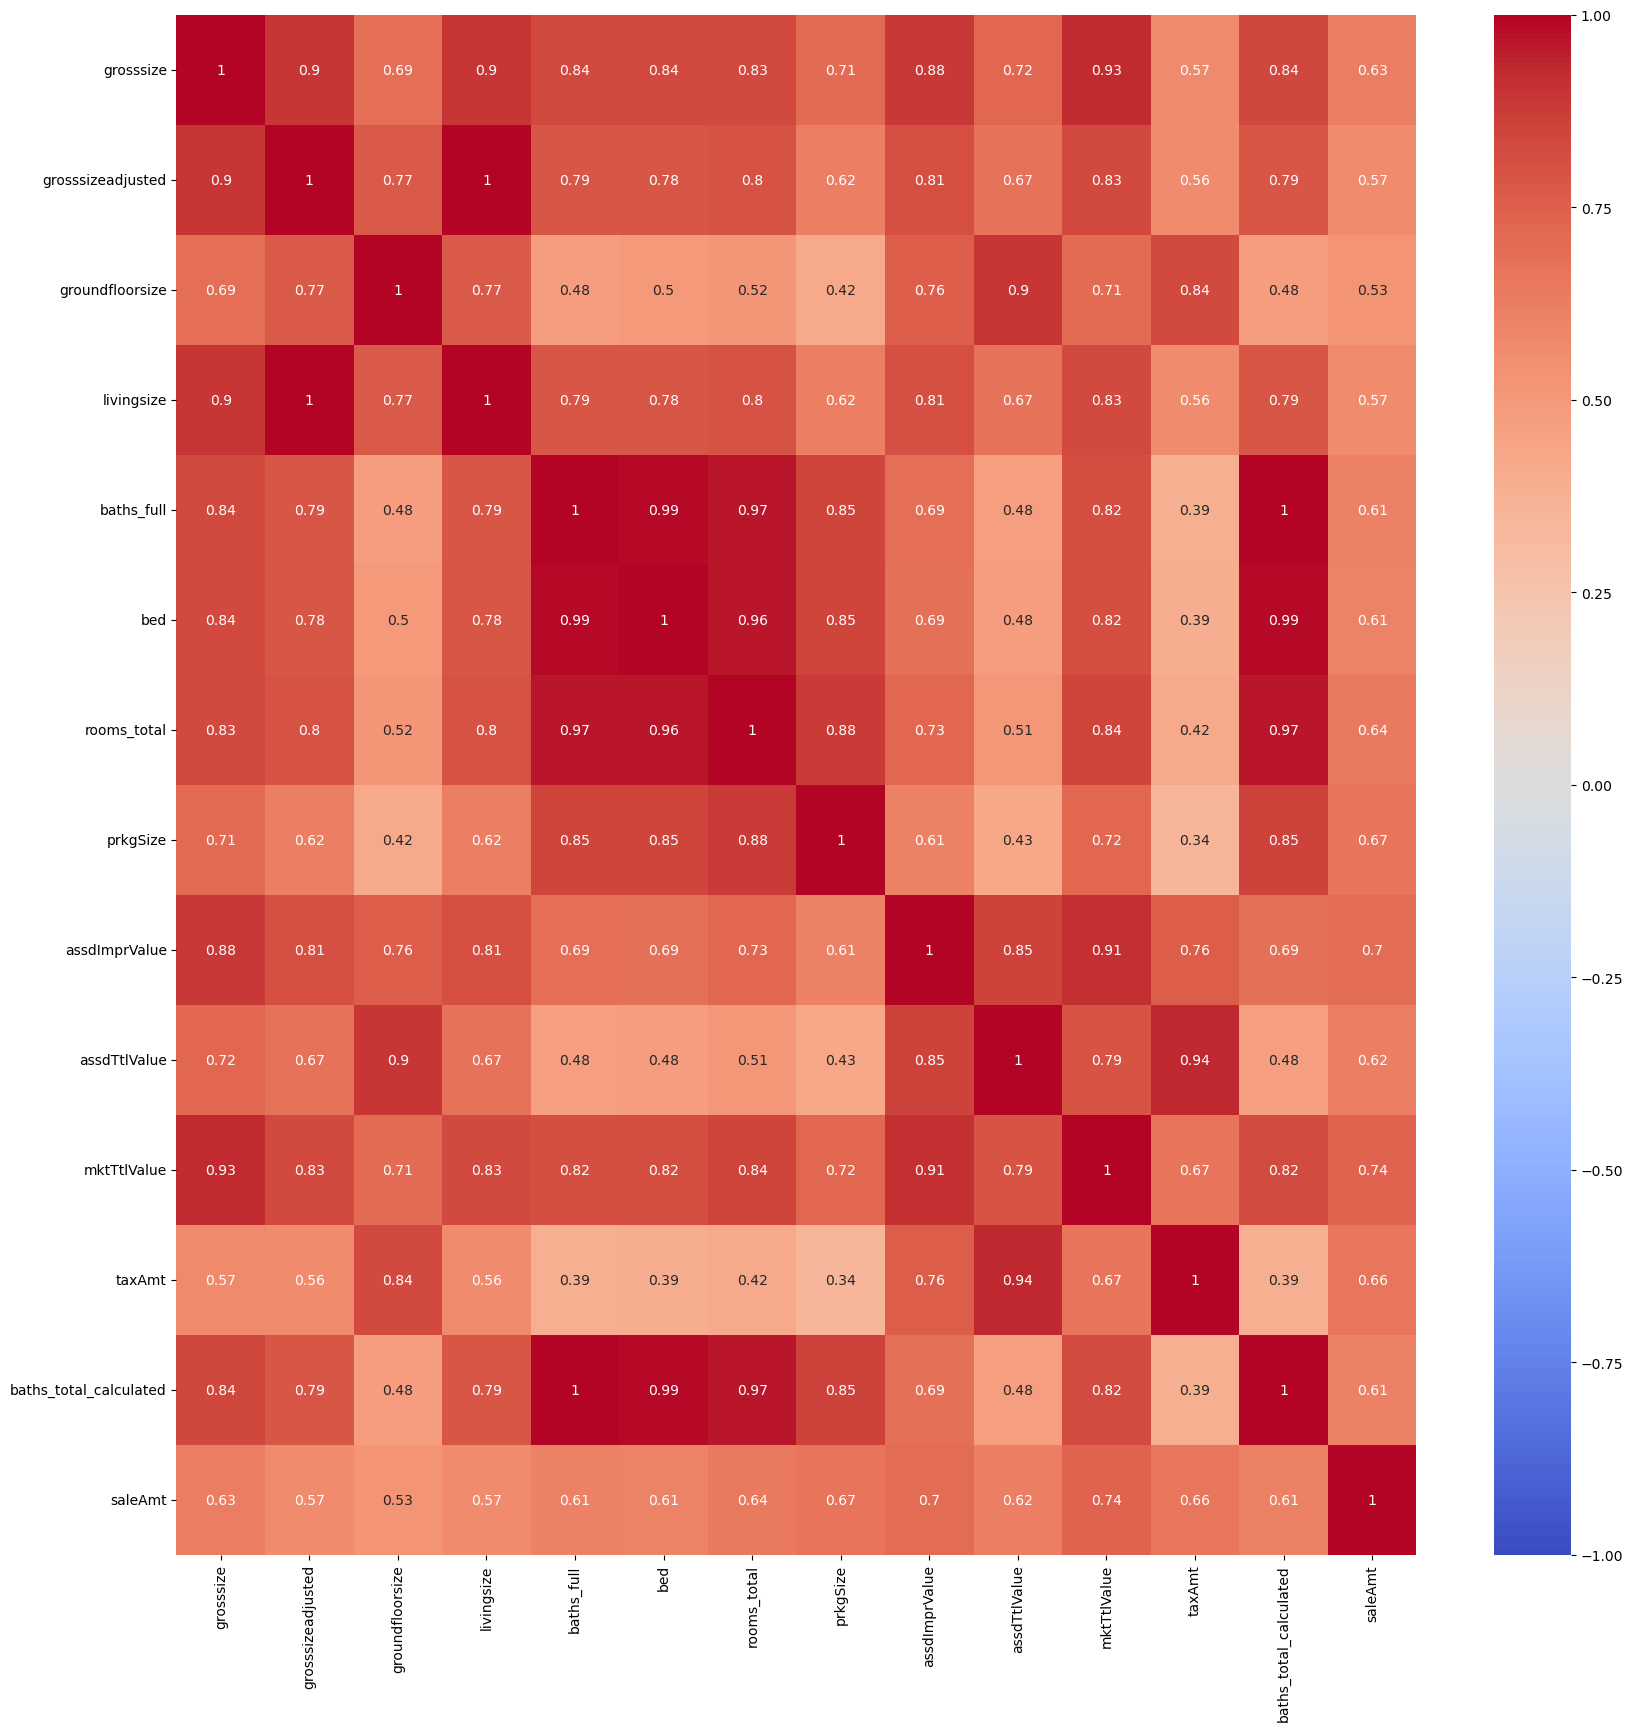

In [12]:
num_cols = [x for x in num_cols if x != 'saleAmt'] + ['saleAmt']
corr = property_df[num_cols].corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

## Analysis on Categorical Columns

In [13]:
property_df.describe(include='O')

,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,5147,5147,5147,5147,5147,5147,5147,5147,5147,5147,5147,5147
unique,30,7,29,10,6,12,2930,5,11,5,6,4
top,SINGLE FAMILY RESIDENCE,RESIDENTIAL,SFR,FORCED AIR,CENTRAL,BRICK VENEER,2005-03-04,AVERAGE,FRAME,WOOD,"Garage, Attached",CONVENTIONAL HOUSE
freq,2479,4978,2556,4239,2835,2421,33,2674,3195,3267,3361,2981


## Convert Required Categorical Columns to Numerical Columns for SVM

In [16]:
data = property_df

# Define a significance level (alpha) for the ANOVA test
alpha = 0.05

# Initialize a list to store columns with significant dependency
significant_cols = []

# Iterate through categorical columns
categorical_columns = data.columns[property_df.dtypes == 'object']
# categorical_columns = ['property_type', 'absenteeInd', 'heatingtype', 'coolingtype', 'wallType', 'saleTransType', 'condition', 'constructiontype', 'frameType', 'prkgType', 'bldgType']

for column in categorical_columns:
    # Perform ANOVA test for independence
    groups = [data[data[column] == category]['saleAmt'] for category in data[column].unique()]
    f_statistic, p_value = f_oneway(*groups)
    
    # Check if the p-value is less than alpha (indicating significant dependency)
    if p_value < alpha:
        significant_cols.append(column)

# Select only the significant columns from the dataset
data_filtered = data[significant_cols + ['saleAmt']]

# Perform target encoding for the selected columns
encoder = ce.TargetEncoder()
data_encoded = encoder.fit_transform(data_filtered.drop('saleAmt', axis=1), data_filtered['saleAmt'])

# Combine the encoded data with the original 'saleAmt' column
property_df_encoded = pd.concat([data_encoded, data_filtered['saleAmt']], axis=1)

property_df_encoded.head(5)

,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType,saleAmt
0,796241.217426,691279.568903,803463.734742,677479.963671,704002.031041,850453.637753,713242.190135,6.061591e+05,685772.730203,741104.830425,603424.419521,2.399808e+06,501930.0
1,393683.553323,691279.568903,393683.553323,677479.963671,701893.005226,828838.765778,676663.905204,6.061591e+05,685772.730203,741104.830425,786176.916989,6.092664e+05,179350.0
2,796241.217426,691279.568903,803463.734742,677479.963671,704002.031041,850453.637753,792087.341937,7.907225e+05,685772.730203,741104.830425,786176.916989,7.643636e+05,1900000.0
3,796241.217426,691279.568903,803463.734742,677479.963671,704002.031041,850453.637753,832184.472070,6.061591e+05,744620.611224,744620.611224,786176.916989,7.643636e+05,1100000.0
4,796241.217426,691279.568903,803463.734742,677479.963671,704002.031041,850453.637753,751763.406140,1.201011e+06,744620.611224,744620.611224,786176.916989,7.643636e+05,798000.0


In [17]:
# Drop categorical columns in property_df
property_df = property_df.select_dtypes(exclude=['object'])

# Merge the encoded categorical columns data to property_df
property_df = pd.concat([property_df, property_df_encoded.drop('saleAmt', axis=1)], axis=1)
property_df.describe(include='all')

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5.147000e+03,5.147000e+03,5.147000e+03,5147.000000,5147.000000,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5.147000e+03,5147.000000,5.147000e+03
mean,2909.412862,1982.077132,1647.700818,1982.077132,2.071304,3.543423,7.492326,495.264846,4.645036e+04,7.128977e+04,8.490291e+05,6541.914312,2.944822,7.448479e+05,6.912288e+05,7.392740e+05,6.912433e+05,7.417029e+05,7.399729e+05,7.379896e+05,7.480519e+05,7.448770e+05,7.309487e+05,7.403743e+05,744761.478359,7.450742e+05
std,8699.439421,5067.840521,4284.518558,5067.840521,13.268863,13.558907,24.028648,1172.644111,1.561694e+05,2.439678e+05,2.115490e+06,21363.092294,13.268904,2.353568e+06,7.706794e+05,2.981515e+05,7.701445e+05,3.000136e+05,2.531116e+05,1.853134e+05,2.866732e+05,2.363256e+05,2.549569e+05,7.295949e+04,118516.285610,2.788011e+05
min,90.000000,90.000000,8.000000,90.000000,0.000000,1.000000,1.000000,86.000000,2.900000e+02,3.430000e+02,1.300000e+03,33.840000,0.000000,5.000000e+02,3.936836e+05,6.912796e+05,3.936836e+05,5.515735e+05,7.018930e+05,5.245341e+05,5.162916e+05,6.061591e+05,6.097213e+05,6.275322e+05,392588.149215,6.092664e+05
25%,1027.500000,970.000000,857.000000,970.000000,1.000000,2.000000,5.000000,260.000000,1.972400e+04,2.889500e+04,4.086000e+05,2713.380000,2.000000,3.290000e+05,3.936836e+05,6.912796e+05,3.936836e+05,6.774800e+05,7.018930e+05,5.245341e+05,6.920765e+05,6.061591e+05,6.857727e+05,7.411048e+05,786176.916989,6.092664e+05
50%,1938.000000,1312.000000,1121.000000,1312.000000,1.000000,3.000000,6.000000,480.000000,2.725100e+04,4.545300e+04,6.459000e+05,4257.880000,2.000000,4.980000e+05,7.962412e+05,6.912796e+05,8.034637e+05,6.774800e+05,7.040020e+05,8.288388e+05,7.159185e+05,6.061591e+05,6.857727e+05,7.411048e+05,786176.916989,7.643636e+05
75%,3214.500000,2006.500000,1592.000000,2006.500000,2.000000,4.000000,8.000000,506.000000,3.926400e+04,6.301250e+04,8.931500e+05,5956.320000,3.000000,7.600000e+05,7.962412e+05,6.912796e+05,8.034637e+05,6.774800e+05,7.040020e+05,8.504536e+05,7.502952e+05,7.907225e+05,7.446206e+05,7.446206e+05,786176.916989,7.643636e+05
max,362967.000000,165530.000000,172081.000000,165530.000000,518.000000,518.000000,966.000000,50626.000000,5.077697e+06,1.120128e+07,7.809005e+07,982413.360000,518.000000,1.042500e+08,9.974938e+06,3.182450e+06,9.974938e+06,2.836450e+06,2.599094e+06,2.113130e+06,1.421175e+07,1.968083e+06,3.231621e+06,1.590885e+06,869456.297873,2.399808e+06


In [18]:
property_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5147 entries, 0 to 5146
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grosssize               5147 non-null   float64
 1   grosssizeadjusted       5147 non-null   float64
 2   groundfloorsize         5147 non-null   float64
 3   livingsize              5147 non-null   float64
 4   baths_full              5147 non-null   float64
 5   bed                     5147 non-null   float64
 6   rooms_total             5147 non-null   float64
 7   prkgSize                5147 non-null   float64
 8   assdImprValue           5147 non-null   float64
 9   assdTtlValue            5147 non-null   float64
 10  mktTtlValue             5147 non-null   float64
 11  taxAmt                  5147 non-null   float64
 12  baths_total_calculated  5147 non-null   float64
 13  saleAmt                 5147 non-null   float64
 14  property_type           5147 non-null   

## Normalize Data

In [19]:
scaler = MinMaxScaler()

property_df_normalized = scaler.fit_transform(property_df)
property_df_normalized = pd.DataFrame(property_df_normalized, columns=property_df.columns)

property_df_normalized.describe(include='all')

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000
mean,0.007770,0.011437,0.009529,0.011437,0.003999,0.004920,0.006728,0.008098,0.009091,0.006334,0.010856,0.006625,0.005685,0.007140,0.031055,0.019266,0.031056,0.083212,0.020072,0.134367,0.016922,0.101854,0.046236,0.117135,0.738513,0.075847
std,0.023974,0.030632,0.024899,0.030632,0.025616,0.026226,0.024900,0.023202,0.030758,0.021781,0.027091,0.021746,0.025616,0.022576,0.080436,0.119683,0.080380,0.131304,0.133413,0.116652,0.020932,0.173523,0.097241,0.075735,0.248531,0.155708
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002584,0.005319,0.004934,0.005319,0.001931,0.001934,0.004145,0.003443,0.003828,0.002549,0.005216,0.002728,0.003861,0.003151,0.000000,0.000000,0.000000,0.055104,0.000000,0.000000,0.012835,0.000000,0.029006,0.117893,0.825362,0.000000
50%,0.005093,0.007386,0.006468,0.007386,0.001931,0.003868,0.005181,0.007796,0.005310,0.004027,0.008255,0.004300,0.003861,0.004772,0.042015,0.000000,0.042769,0.055104,0.001112,0.191556,0.014576,0.000000,0.029006,0.117893,0.825362,0.086620
75%,0.008610,0.011584,0.009205,0.011584,0.003861,0.005803,0.007254,0.008310,0.007676,0.005595,0.011421,0.006029,0.005792,0.007285,0.042015,0.000000,0.042769,0.055104,0.001112,0.205162,0.017086,0.135517,0.051451,0.121543,0.825362,0.086620
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
property_df_normalized.head(5)

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
0,0.005567,0.014597,0.030871,0.014597,0.001931,0.001934,0.006218,0.022042,0.007421,0.006243,0.012930,0.007055,0.005792,0.004810,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.014381,0.000000,0.029006,0.117893,0.442127,1.00000
1,0.002147,0.004709,0.005004,0.004709,0.001931,0.001934,0.004145,0.008101,0.004327,0.001957,0.004085,0.002070,0.003861,0.001716,0.000000,0.0,0.000000,0.055104,0.000000,0.191556,0.011710,0.000000,0.029006,0.117893,0.825362,0.00000
2,0.015446,0.019070,0.010769,0.019070,0.003861,0.007737,0.010363,0.014286,0.008146,0.006963,0.014417,0.007444,0.007722,0.018221,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.020138,0.135517,0.029006,0.117893,0.825362,0.08662
3,0.008840,0.010058,0.006137,0.010058,0.005792,0.005803,0.008290,0.007796,0.000712,0.003456,0.007179,0.003657,0.005792,0.010547,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.023066,0.000000,0.051451,0.121543,0.825362,0.08662
4,0.013619,0.012996,0.012971,0.012996,0.005792,0.005803,0.009326,0.009220,0.008742,0.008267,0.017109,0.008751,0.007722,0.007650,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.017193,0.436773,0.051451,0.121543,0.825362,0.08662


In [21]:
property_df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5147 entries, 0 to 5146
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   grosssize               5147 non-null   float64
 1   grosssizeadjusted       5147 non-null   float64
 2   groundfloorsize         5147 non-null   float64
 3   livingsize              5147 non-null   float64
 4   baths_full              5147 non-null   float64
 5   bed                     5147 non-null   float64
 6   rooms_total             5147 non-null   float64
 7   prkgSize                5147 non-null   float64
 8   assdImprValue           5147 non-null   float64
 9   assdTtlValue            5147 non-null   float64
 10  mktTtlValue             5147 non-null   float64
 11  taxAmt                  5147 non-null   float64
 12  baths_total_calculated  5147 non-null   float64
 13  saleAmt                 5147 non-null   float64
 14  property_type           5147 non-null   

In [22]:
min_sale_amt = property_df_normalized["saleAmt"].min()
max_sale_amt = property_df_normalized["saleAmt"].max()

print("Minimum saleAmt:", min_sale_amt)
print("Maximum saleAmt:", max_sale_amt)

Minimum saleAmt: 0.0
Maximum saleAmt: 0.9999999999999999


In [23]:
property_df_normalized["saleAmt"].isna().sum()

0

In [24]:
property_df_normalized["saleAmt"].describe()

count    5147.000000
mean        0.007140
std         0.022576
min         0.000000
25%         0.003151
50%         0.004772
75%         0.007285
max         1.000000
Name: saleAmt, dtype: float64

In [25]:
bins = [-1, 0.003151, 0.004772, 0.007285, 1]
labels = ['Economical Price', 'Budget-Friendly Price', 'Standard Price', 'Premium Price']

property_df_normalized['saleAmtCategory'] = pd.cut(property_df_normalized['saleAmt'], bins=bins, labels=labels)

In [26]:
property_df_normalized.head(5)

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,saleAmt,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType,saleAmtCategory
0,0.005567,0.014597,0.030871,0.014597,0.001931,0.001934,0.006218,0.022042,0.007421,0.006243,0.012930,0.007055,0.005792,0.004810,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.014381,0.000000,0.029006,0.117893,0.442127,1.00000,Standard Price
1,0.002147,0.004709,0.005004,0.004709,0.001931,0.001934,0.004145,0.008101,0.004327,0.001957,0.004085,0.002070,0.003861,0.001716,0.000000,0.0,0.000000,0.055104,0.000000,0.191556,0.011710,0.000000,0.029006,0.117893,0.825362,0.00000,Economical Price
2,0.015446,0.019070,0.010769,0.019070,0.003861,0.007737,0.010363,0.014286,0.008146,0.006963,0.014417,0.007444,0.007722,0.018221,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.020138,0.135517,0.029006,0.117893,0.825362,0.08662,Premium Price
3,0.008840,0.010058,0.006137,0.010058,0.005792,0.005803,0.008290,0.007796,0.000712,0.003456,0.007179,0.003657,0.005792,0.010547,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.023066,0.000000,0.051451,0.121543,0.825362,0.08662,Premium Price
4,0.013619,0.012996,0.012971,0.012996,0.005792,0.005803,0.009326,0.009220,0.008742,0.008267,0.017109,0.008751,0.007722,0.007650,0.042015,0.0,0.042769,0.055104,0.001112,0.205162,0.017193,0.436773,0.051451,0.121543,0.825362,0.08662,Premium Price


In [27]:
property_df_normalized["saleAmtCategory"].isna().sum()

0

In [28]:
# property_df_normalized.to_csv("C:/Users/Amith Nandivada/Desktop/Amith/MS/CUB/Boulder Course Material/Fall23/Machine Learning/Assignment/Data/property_data_supervised.csv", mode='w', index=False)

## Support Vector Machines

In [29]:
y = property_df_normalized["saleAmtCategory"]
X = property_df_normalized.drop(['saleAmt', 'saleAmtCategory'], axis = 1)

X.columns

Index(['grosssize', 'grosssizeadjusted', 'groundfloorsize', 'livingsize', 'baths_full', 'bed', 'rooms_total', 'prkgSize', 'assdImprValue', 'assdTtlValue', 'mktTtlValue', 'taxAmt', 'baths_total_calculated', 'property_type', 'propsubtype', 'proptype', 'heatingtype', 'coolingtype', 'wallType', 'saleRecDate', 'condition', 'constructiontype', 'frameType', 'prkgType', 'bldgType'], dtype='object')

In [30]:
y.isna().sum()

0

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
y_train.describe(include='all')

count               4117
unique                 4
top       Standard Price
freq                1062
Name: saleAmtCategory, dtype: object

In [33]:
X_train.describe(include='all')

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000,4117.000000
mean,0.008051,0.011737,0.009713,0.011737,0.004251,0.005171,0.006998,0.008338,0.009278,0.006480,0.011094,0.006718,0.005942,0.031996,0.019884,0.031982,0.083325,0.019617,0.134591,0.017036,0.101530,0.046849,0.116964,0.738949,0.076559
std,0.026422,0.033339,0.026533,0.033339,0.028510,0.029057,0.027762,0.025823,0.033222,0.023619,0.029822,0.023028,0.028498,0.085020,0.121831,0.084964,0.131817,0.131849,0.116955,0.022670,0.173863,0.099850,0.074678,0.247986,0.157273
min,0.000000,0.000000,0.000918,0.000000,0.000000,0.000000,0.000000,0.000277,0.000046,0.000016,0.000025,0.000013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002596,0.005349,0.004928,0.005349,0.001931,0.001934,0.004145,0.003443,0.003847,0.002541,0.005216,0.002729,0.003861,0.000000,0.000000,0.000000,0.055104,0.000000,0.000000,0.012842,0.000000,0.029006,0.117893,0.825362,0.000000
50%,0.005186,0.007435,0.006491,0.007435,0.001931,0.003868,0.005181,0.007796,0.005330,0.004046,0.008274,0.004316,0.003861,0.042015,0.000000,0.042769,0.055104,0.001112,0.191556,0.014565,0.000000,0.029006,0.117893,0.825362,0.086620
75%,0.008697,0.011642,0.009205,0.011642,0.003861,0.005803,0.007254,0.008310,0.007647,0.005621,0.011451,0.006036,0.005792,0.042015,0.000000,0.042769,0.055104,0.001112,0.205162,0.017047,0.135517,0.051451,0.121543,0.825362,0.086620
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
y_test.describe(include='all')

count                 1030
unique                   4
top       Economical Price
freq                   281
Name: saleAmtCategory, dtype: object

In [35]:
X_test.describe(include='all')

,grosssize,grosssizeadjusted,groundfloorsize,livingsize,baths_full,bed,rooms_total,prkgSize,assdImprValue,assdTtlValue,mktTtlValue,taxAmt,baths_total_calculated,property_type,propsubtype,proptype,heatingtype,coolingtype,wallType,saleRecDate,condition,constructiontype,frameType,prkgType,bldgType
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,0.006643,0.010236,0.008795,0.010236,0.002989,0.003914,0.005648,0.007139,0.008345,0.005749,0.009904,0.006252,0.004658,0.027293,0.016797,0.027356,0.082759,0.021887,0.133474,0.016469,0.103150,0.043787,0.117818,0.736769,0.073003
std,0.008950,0.015650,0.016846,0.015650,0.005370,0.007826,0.004036,0.004877,0.017767,0.011857,0.010567,0.015610,0.005616,0.058520,0.110705,0.058472,0.129295,0.139541,0.115487,0.011625,0.172236,0.086030,0.079853,0.250811,0.149327
min,0.000606,0.001330,0.000000,0.001330,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002555,0.005266,0.004946,0.005266,0.001931,0.001934,0.004145,0.003443,0.003724,0.002564,0.005218,0.002718,0.003861,0.000000,0.000000,0.000000,0.055104,0.000000,0.000000,0.012785,0.000000,0.029006,0.117893,0.825362,0.000000
50%,0.004743,0.007308,0.006413,0.007308,0.001931,0.003868,0.005181,0.007440,0.005255,0.003978,0.008198,0.004245,0.003861,0.042015,0.000000,0.042769,0.055104,0.001112,0.191556,0.014611,0.000000,0.029006,0.117893,0.825362,0.086620
75%,0.008314,0.011421,0.009165,0.011421,0.003861,0.005803,0.007254,0.008271,0.007736,0.005533,0.011358,0.005928,0.005792,0.042015,0.000000,0.042769,0.055104,0.001112,0.205162,0.017281,0.135517,0.051451,0.121543,0.825362,0.086620
max,0.132651,0.290957,0.421286,0.290957,0.156371,0.232108,0.077720,0.041828,0.279029,0.217599,0.210244,0.352382,0.156371,1.000000,0.827990,1.000000,1.000000,1.000000,0.646631,0.311998,1.000000,1.000000,1.000000,1.000000,1.000000


## SVM with default Kernel = 'rbf'


In [41]:
svm = SVC()

# Train the model on the training data
svm.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_SVM = svm.predict(X_test)

# Print Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_SVM)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred_SVM)

print(accuracy)
print("\n")
print(cm_svm)

0.4815533980582524


[[ 10 107   5 127]
 [ 10 213   3  55]
 [  6   5 111 154]
 [  5  42  15 162]]


In [38]:
class_names = y_train.unique()

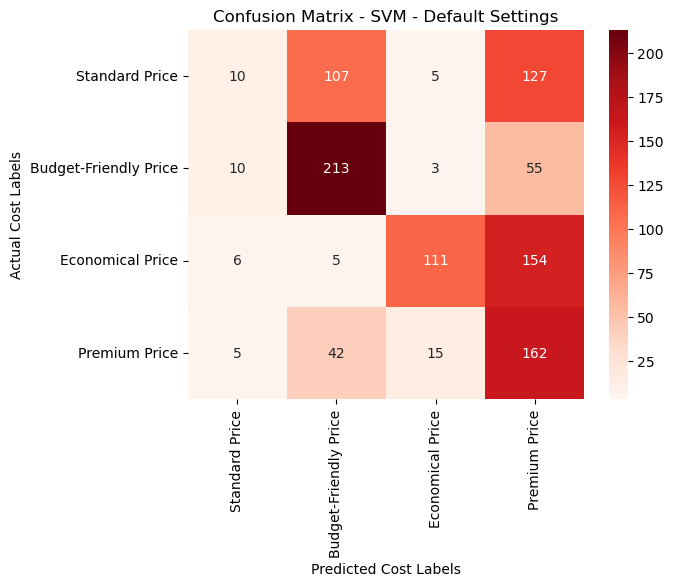

In [39]:
sns.heatmap(cm_svm, annot=True, cmap="Reds", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SVM - Default Settings")
plt.xlabel("Predicted Cost Labels")
plt.ylabel("Actual Cost Labels")
plt.show()

### Now let's update the Cost Value to 10

In [46]:
svm_c = SVC(C=10)

# Train the model on the training data
svm_c.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_SVM_C = svm_c.predict(X_test)

# Print Confusion Matrix
cm_svm_c = confusion_matrix(y_test, y_pred_SVM_C)

# Calculate the accuracy of the predictions
accuracy_c = accuracy_score(y_test, y_pred_SVM_C)

print(accuracy_c)
print("\n")
print(cm_svm_c)

0.47572815533980584


[[ 14  94   2 139]
 [ 15 199   3  64]
 [  3   3 108 162]
 [  2  39  14 169]]


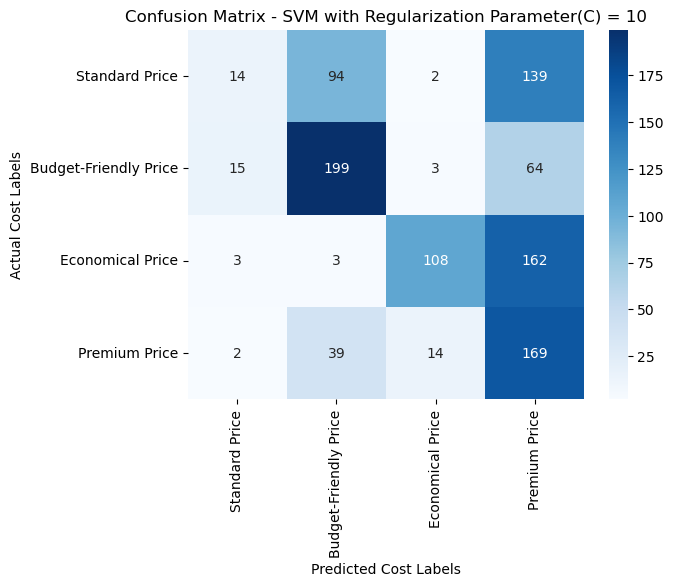

In [43]:
sns.heatmap(cm_svm_c, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SVM with Regularization Parameter(C) = 10")
plt.xlabel("Predicted Cost Labels")
plt.ylabel("Actual Cost Labels")
plt.show()

### Now let's update the Cost Value to 100

In [45]:
svm_c_u = SVC(C=100)

# Train the model on the training data
svm_c_u.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_SVM_C_U = svm_c_u.predict(X_test)

# Print Confusion Matrix
cm_svm_c_u = confusion_matrix(y_test, y_pred_SVM_C_U)

# Calculate the accuracy of the predictions
accuracy_c_u = accuracy_score(y_test, y_pred_SVM_C_U)

print(accuracy_c_u)
print("\n")
print(cm_svm_c_u)

0.5427184466019418


[[102  57   7  83]
 [100 167   4  10]
 [ 15   2 150 109]
 [ 44  14  26 140]]


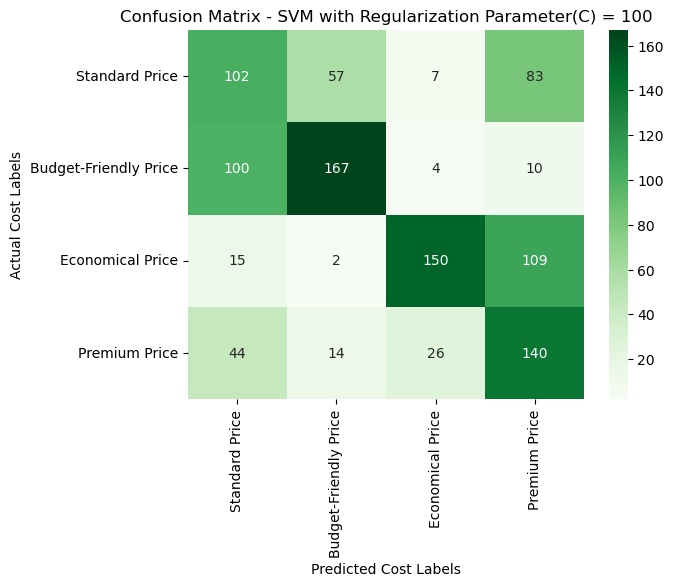

In [47]:
sns.heatmap(cm_svm_c_u, annot=True, cmap="Greens", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SVM with Regularization Parameter(C) = 100")
plt.xlabel("Predicted Cost Labels")
plt.ylabel("Actual Cost Labels")
plt.show()

## SVM with Polynomial Kernel

In [50]:
svm_poly = SVC(kernel='poly', C = 1)

# Train the model on the training data
svm_poly.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_SVM_Poly = svm_poly.predict(X_test)

# Print Confusion Matrix
cm_svm_poly = confusion_matrix(y_test, y_pred_SVM_Poly)

# Calculate the accuracy of the predictions
accuracy_poly = accuracy_score(y_test, y_pred_SVM_Poly)

print(accuracy_poly)
print("\n")
print(cm_svm_poly)

0.46601941747572817


[[  6 116   2 125]
 [  7 221   2  51]
 [  6  20  99 151]
 [  0  58  12 154]]


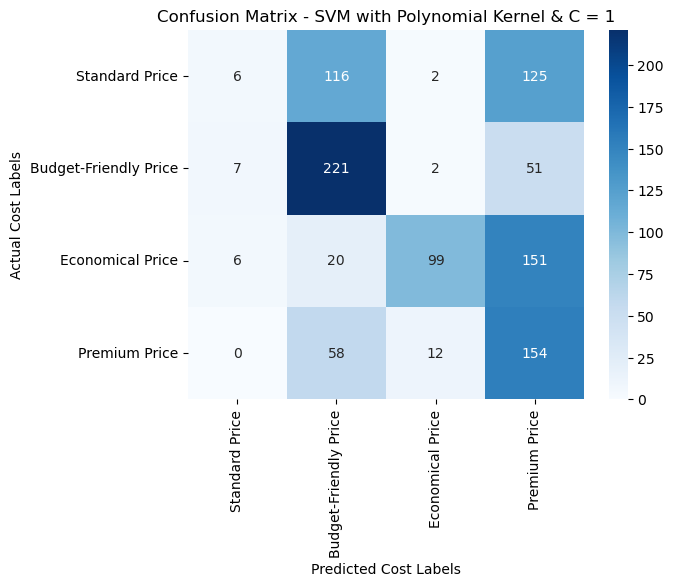

In [49]:
sns.heatmap(cm_svm_poly, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SVM with Polynomial Kernel & C = 1")
plt.xlabel("Predicted Cost Labels")
plt.ylabel("Actual Cost Labels")
plt.show()

### Now let's update the Cost Value to 10

In [52]:
svm_poly_1 = SVC(kernel='poly', C = 10)

# Train the model on the training data
svm_poly_1.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_SVM_Poly_1 = svm_poly_1.predict(X_test)

# Print Confusion Matrix
cm_svm_poly_1 = confusion_matrix(y_test, y_pred_SVM_Poly_1)

# Calculate the accuracy of the predictions
accuracy_poly_1 = accuracy_score(y_test, y_pred_SVM_Poly_1)

print(accuracy_poly_1)
print("\n")
print(cm_svm_poly_1)

0.5097087378640777


[[ 20 103   4 122]
 [ 16 221   5  39]
 [  4  17 139 116]
 [ 15  45  19 145]]


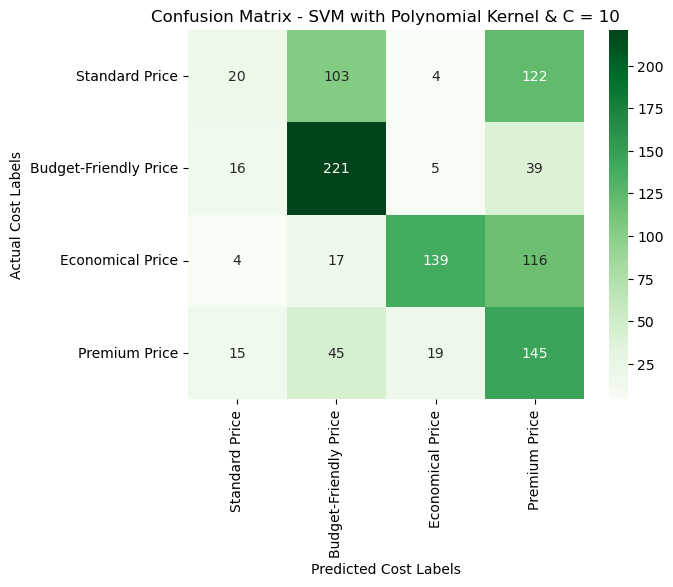

In [53]:
sns.heatmap(cm_svm_poly_1, annot=True, cmap="Greens", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SVM with Polynomial Kernel & C = 10")
plt.xlabel("Predicted Cost Labels")
plt.ylabel("Actual Cost Labels")
plt.show()

### Now let's update the Cost Value to 100

In [55]:
svm_poly_2 = SVC(kernel='poly', C = 100)

# Train the model on the training data
svm_poly_2.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_SVM_Poly_2 = svm_poly_2.predict(X_test)

# Print Confusion Matrix
cm_svm_poly_2 = confusion_matrix(y_test, y_pred_SVM_Poly_2)

# Calculate the accuracy of the predictions
accuracy_poly_2 = accuracy_score(y_test, y_pred_SVM_Poly_2)

print(accuracy_poly_2)
print("\n")
print(cm_svm_poly_2)

0.583495145631068


[[ 87  87   5  70]
 [ 50 221   4   6]
 [ 15   6 155 100]
 [ 43  21  22 138]]


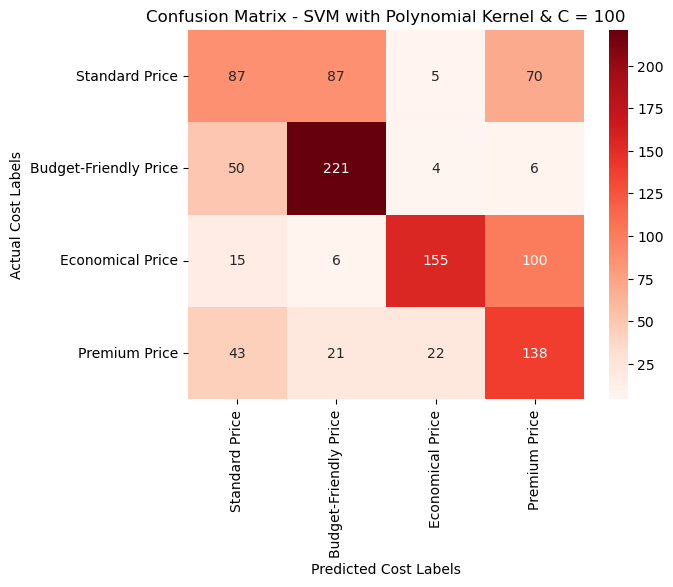

In [56]:
sns.heatmap(cm_svm_poly_2, annot=True, cmap="Reds", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SVM with Polynomial Kernel & C = 100")
plt.xlabel("Predicted Cost Labels")
plt.ylabel("Actual Cost Labels")
plt.show()

## SVM with Sigmoid Kernel

In [57]:
svm_sigmoid = SVC(kernel="sigmoid", C = 1)

# Train the model on the training data
svm_sigmoid.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_SVM_Sigmoid = svm_sigmoid.predict(X_test)

# Print Confusion Matrix
cm_svm_sigmoid = confusion_matrix(y_test, y_pred_SVM_Sigmoid)

# Calculate the accuracy of the predictions
accuracy_sigmoid = accuracy_score(y_test, y_pred_SVM_Sigmoid)

print(accuracy_sigmoid)
print("\n")
print(cm_svm_sigmoid)

0.4029126213592233


[[156  62  16  15]
 [165 110   3   3]
 [ 77  31 121  47]
 [103  41  52  28]]


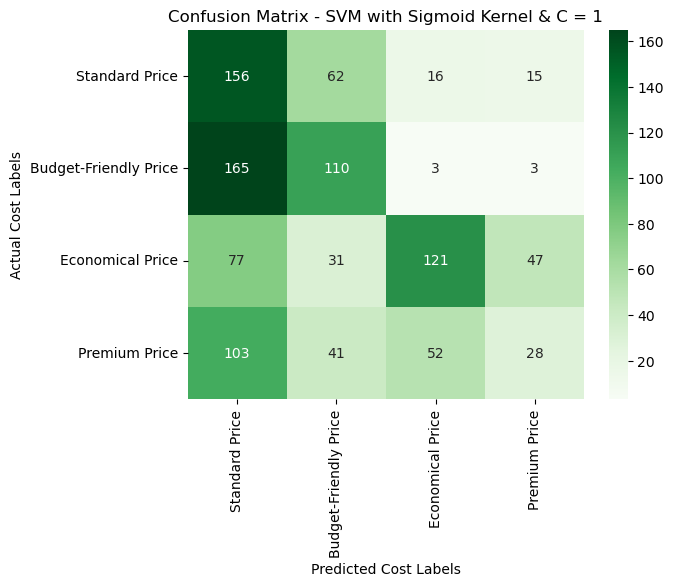

In [58]:
sns.heatmap(cm_svm_sigmoid, annot=True, cmap="Greens", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SVM with Sigmoid Kernel & C = 1")
plt.xlabel("Predicted Cost Labels")
plt.ylabel("Actual Cost Labels")
plt.show()

### Now let's update the Cost Value to 10

In [59]:
svm_sigmoid_1 = SVC(kernel="sigmoid", C = 10)

# Train the model on the training data
svm_sigmoid_1.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_SVM_Sigmoid_1 = svm_sigmoid_1.predict(X_test)

# Print Confusion Matrix
cm_svm_sigmoid_1 = confusion_matrix(y_test, y_pred_SVM_Sigmoid_1)

# Calculate the accuracy of the predictions
accuracy_sigmoid_1 = accuracy_score(y_test, y_pred_SVM_Sigmoid_1)

print(accuracy_sigmoid_1)
print("\n")
print(cm_svm_sigmoid_1)

0.3990291262135922


[[178  52   4  15]
 [159 118   2   2]
 [102  29  78  67]
 [130  31  26  37]]


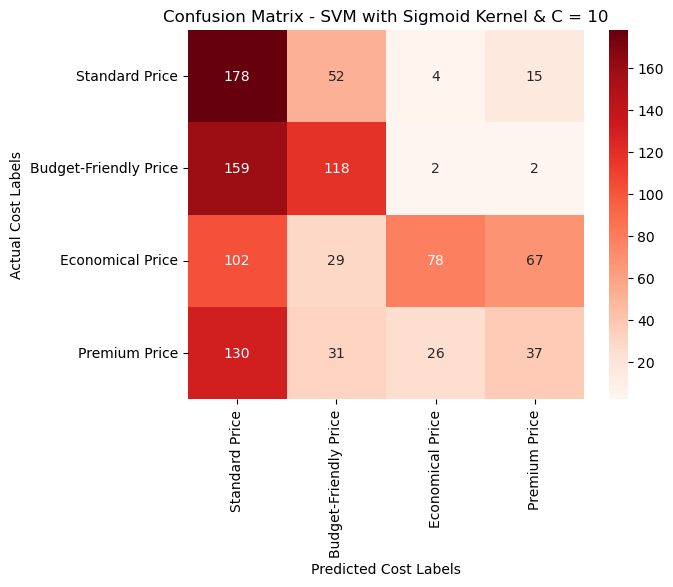

In [60]:
sns.heatmap(cm_svm_sigmoid_1, annot=True, cmap="Reds", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SVM with Sigmoid Kernel & C = 10")
plt.xlabel("Predicted Cost Labels")
plt.ylabel("Actual Cost Labels")
plt.show()

## Now let's update the Cost Value to 100

In [61]:
svm_sigmoid_2 = SVC(kernel="sigmoid", C = 100)

# Train the model on the training data
svm_sigmoid_2.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_SVM_Sigmoid_2 = svm_sigmoid_1.predict(X_test)

# Print Confusion Matrix
cm_svm_sigmoid_2 = confusion_matrix(y_test, y_pred_SVM_Sigmoid_2)

# Calculate the accuracy of the predictions
accuracy_sigmoid_2 = accuracy_score(y_test, y_pred_SVM_Sigmoid_2)

print(accuracy_sigmoid_2)
print("\n")
print(cm_svm_sigmoid_2)

0.3990291262135922


[[178  52   4  15]
 [159 118   2   2]
 [102  29  78  67]
 [130  31  26  37]]


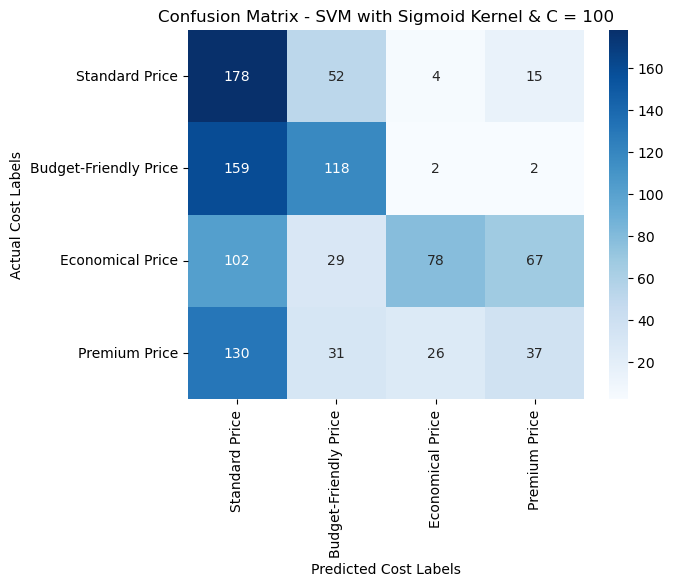

In [62]:
sns.heatmap(cm_svm_sigmoid_2, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SVM with Sigmoid Kernel & C = 100")
plt.xlabel("Predicted Cost Labels")
plt.ylabel("Actual Cost Labels")
plt.show()

## SVC with parameter kernel=’linear'

In [63]:
svm_lin = LinearSVC(random_state=0, tol=1e-05, C = 2)

# Train the model on the training data
svm_lin.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_linear = svm_lin.predict(X_test)

# Print Confusion Matrix
cm_svm_linear = confusion_matrix(y_test, y_pred_linear)

# Calculate the accuracy of the predictions
accuracy_linear = accuracy_score(y_test, y_pred_linear)

print(accuracy_linear)
print("\n")
print(cm_svm_linear)

0.5067961165048543


[[ 11 115  10 113]
 [  6 226   7  42]
 [  9  13 169  85]
 [  7  44  57 116]]


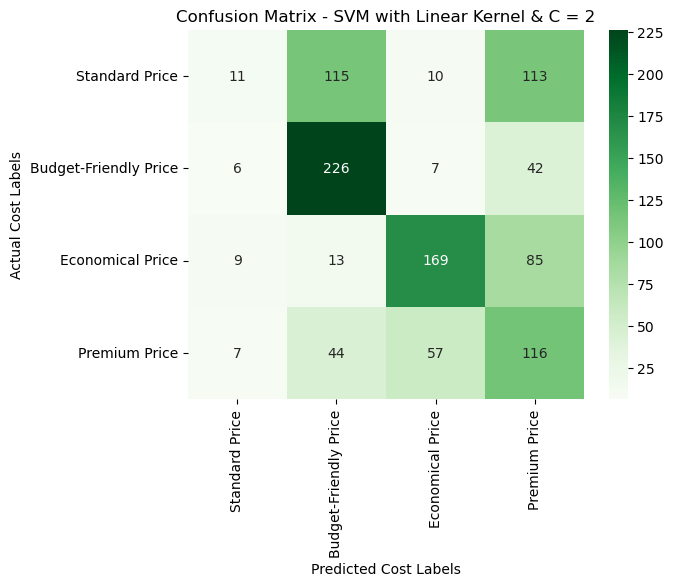

In [64]:
sns.heatmap(cm_svm_linear, annot=True, cmap="Greens", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SVM with Linear Kernel & C = 2")
plt.xlabel("Predicted Cost Labels")
plt.ylabel("Actual Cost Labels")
plt.show()